In [5]:
import pandas as pd

In [6]:
df = pd.read_csv('https://raw.githubusercontent.com/rasbt/'
                 'python-machine-learning-book-2nd-edition'
                '/master/code/ch10/housing.data.txt',
                header=None,
                  sep='\s+')

In [7]:
len(df.columns)

14

In [8]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


In [9]:
df.columns = ['CRIM', 'ZN', 'INDUS', 'CHAS',
               'NOX', 'RM', 'AGE', 'DIS', 'RAD',
               'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns



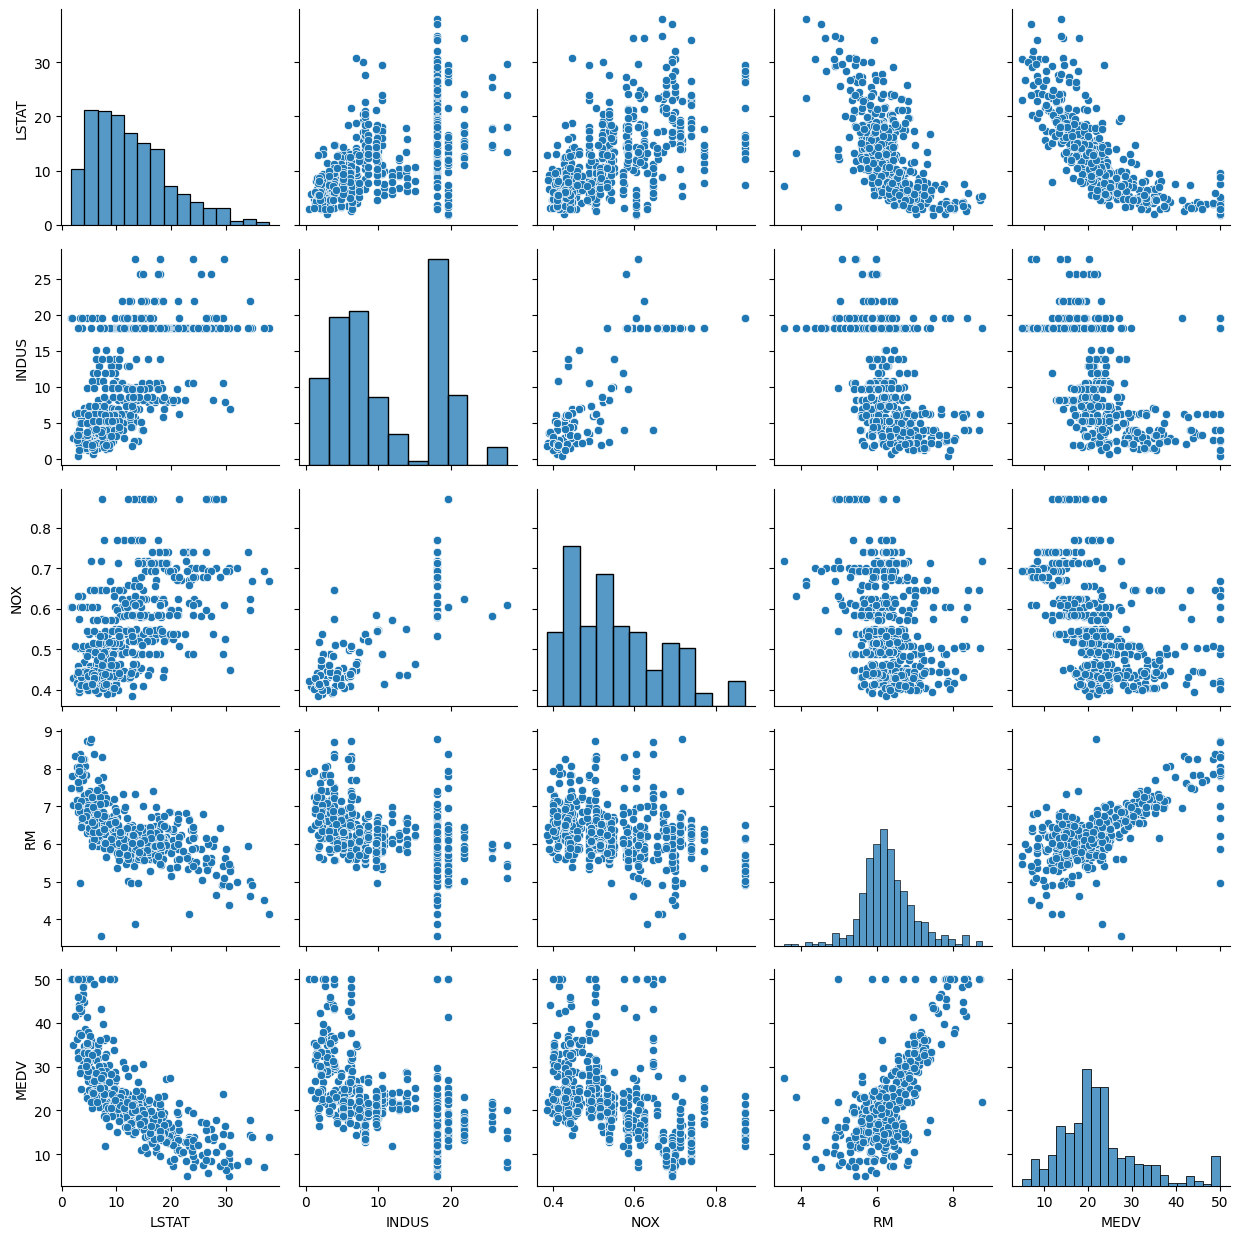

In [11]:
# Exploratory data analysis - 1. Pairwise plots of scatter matrix

cols = ['LSTAT', 'INDUS', 'NOX', 'RM', 'MEDV'] # chosen columns

sns.pairplot(df[cols], height=2.5)
plt.tight_layout()
plt.show()

Note that in contrast to common belief, training a linear regression model does not require that the explanatory or target variables
are normally distributed. The normality assumption is only a requirement for certain statistics and hypothesis tests 

Pearson's correlation coefficient:

r = $\frac{\sum _{i=1}^{n}(x^{(i)}-\mu _x)(y^{(i)}-\mu_ y) }{\sqrt{\sum _{i=1}^{n}(x^{(i)}-\mu _x)^{2}} \sqrt{\sum _{i=1}^{n}(y^{(i)}-\mu _y)^2}} = \frac{\sigma _{xy}}{\sigma _x \sigma _y}$ \
r = 1 , perfect linear correlation, r=-1, perfect inverted linear correlation, r=0, no linear correlation. Covariance between two standardized features is the pearson correlation coefficient.

In [12]:
import numpy as np

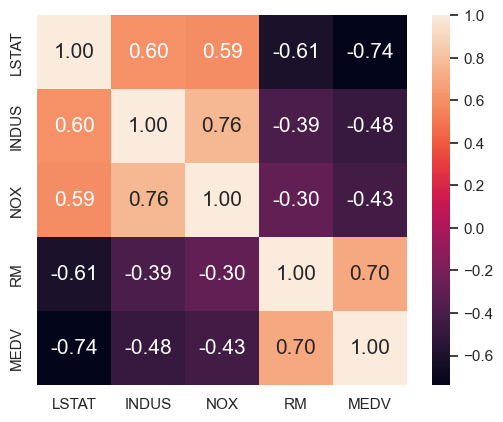

In [13]:
cm = np.corrcoef(df[cols].values.T)
sns.set_theme(font_scale=1.0)
hm = sns.heatmap(cm,
              cbar=True,
               annot=True,
            square=True,
            fmt='.2f',
           annot_kws={'size': 15},
           yticklabels=cols,
          xticklabels=cols)
plt.show()

In [14]:
cm

array([[ 1.        ,  0.60379972,  0.59087892, -0.61380827, -0.73766273],
       [ 0.60379972,  1.        ,  0.76365145, -0.39167585, -0.48372516],
       [ 0.59087892,  0.76365145,  1.        , -0.30218819, -0.42732077],
       [-0.61380827, -0.39167585, -0.30218819,  1.        ,  0.69535995],
       [-0.73766273, -0.48372516, -0.42732077,  0.69535995,  1.        ]])

In regression problems, we use the MSE cost function, because it makes the most sense since we are handling continious valued targets. Let us write a simple class which can fit the model on training data

In [15]:
class LinearRegressionGD():
    def __init__(self, eta=0.001,n_iters = 20):
        self.eta = eta
        self.n_iters = n_iters
    
    def fit(self, X, y):
        self.costs_ = []
        self.weights_ = np.zeros(1+X.shape[1])
        for i in range(self.n_iters):
            output = self.predict(X)
            error = (y-output)
            self.weights_[1:] += self.eta * X.T.dot(error)
            self.weights_[0] += self.eta * error.sum()
            cost = (error**2).sum()/2.0
            self.costs_.append(cost)
        return self
    
    def predict(self,X):
        return np.dot(X, self.weights_[1:]) + self.weights_[0]

In [16]:
X = df[['RM']].values
X.shape

(506, 1)

In [17]:
y = df['MEDV'].values

In [18]:
from sklearn.preprocessing import StandardScaler
sc_x = StandardScaler()
sc_y = StandardScaler()

X_std= sc_x.fit_transform(X)
y_std= sc_y.fit_transform(y[:,np.newaxis]).flatten() # fit_transform expects 2D array, hence the newaxis trick
lr = LinearRegressionGD()


In [19]:
lr.fit(X_std, y_std)

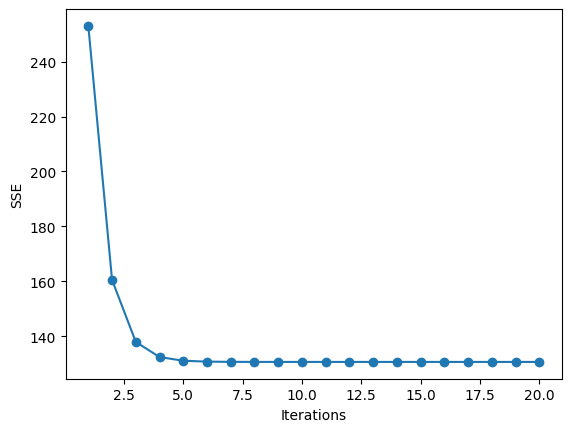

In [20]:
sns.reset_orig()
plt.plot(range(1,lr.n_iters+1), lr.costs_, marker='o')
plt.xlabel('Iterations')
plt.ylabel('SSE')
plt.show()

In [21]:
def render_plot(X,y,model):
    plt.scatter(X,y,c='steelblue', edgecolor='white',s=70)
    plt.plot(X,model.predict(X),color='black',lw=2)
    

In [22]:
render_plot(X_std, y_std, lr)

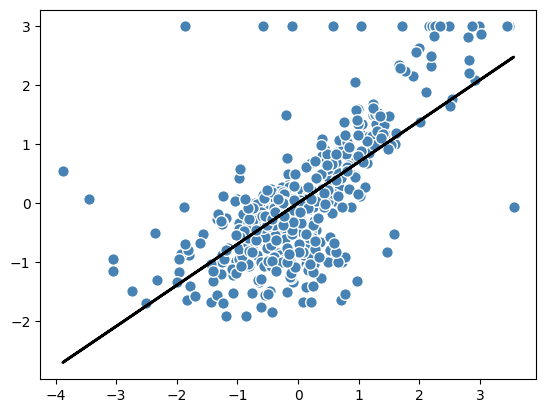

In [23]:
plt.show()

there is a good correlation between number of rooms and median price as our learnt regression line captures the trend but still many samples are far away from the line and we can have a better model. also, the prices seemed to be clipped at 3 in standardized scale.

In [24]:
# to get data in original scale
num_rooms_std = sc_x.transform(np.array([[5.0]]))
price_std = lr.predict(num_rooms_std)
price_orig= sc_y.inverse_transform(price_std[:,np.newaxis])
print(price_orig.flatten())

[10.83993289]


Since , we have standardized the dataset , there is no need to use w_0 , it is already taken care of by the standardization process

In [25]:
print(lr.weights_[1]) # slope
print(lr.weights_[0]) # intercept

0.6953594261783849
-4.831690603168682e-16


The class we wrote does the job , but is very inefficient. if we use sklearn's libraries to get the job done, it internally uses optimized libraries like LIBLINEAR which can help train faster

In [26]:
from sklearn.linear_model import LinearRegression
slr = LinearRegression()
slr.fit(X,y)
slr.intercept_,slr.coef_

(-34.67062077643851, array([9.10210898]))

In [27]:
render_plot(X,y,slr)

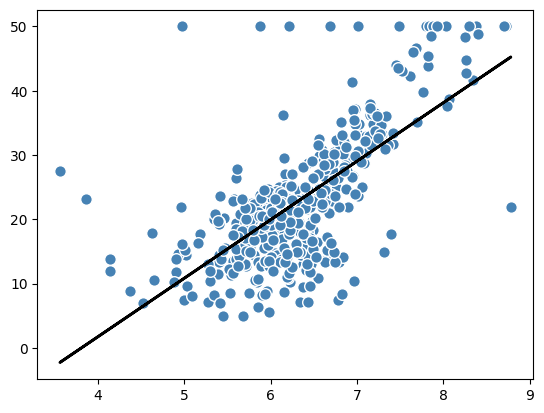

In [28]:
plt.show()

As an alternative to using ML algorithms, analytical methods can be used to solve he linear regression problem. Closed form solution for systems involving linear equations : 
w = $ (X^TX)^{-1}X^Ty $ \
This method finds the optimal solution analytically but it is expensive and when the size of the dataset gets big, you have a large matrix to be inverted which is very expensive. In some cases, the matrix may be invertible forcing us to again go for approximate solutions.

In [29]:
#analytical method
Xb = np.hstack((np.ones((X.shape[0],1)),X))
z = np.linalg.inv(np.dot(Xb.T,Xb))
w = np.dot(np.dot(z,Xb.T),y)
print(w[0],w[1])

-34.67062077643721 9.102108981180052


Fitting robust models using RANSAC [Random Sample Consensus]: 
Small subsets are more susceptible to interference from outliers. Depending on application, we may have to deal with outliers in different ways. There are dedicated algorithms which can detect and remove outliers. In regression problems, we may remove these outliers before fitting the model on data. or we could use algorithms like RANSAC which train the model on subset of data called inliers.


We can summarize the iterative RANSAC algorithm as follows:
1. Select random number of samples to be inliers and fit the model
2. Test all other data points against the fitted model and add those points which fall within the tolerance limit of the inliers
3. REfit the model using all inliers
4. Estimate the error of the model versus the inliers
5. Terminate the algorithm if the performance meets the threshold or fixed number of iterations. go back to step 1 otherwise

In [30]:
from sklearn.linear_model import RANSACRegressor
ransac = RANSACRegressor(LinearRegression(),max_trials=100,min_samples=50,loss='absolute_error',residual_threshold=5.0,random_state=42)
# how is inlier or outlier determined -> using the metric absolute error that is the vertical distance between predicted point and actual point and comparing it against residual threshold which is configurable
ransac.fit(X,y)

RANSACRegressor(estimator=LinearRegression(), min_samples=50, random_state=42,
                residual_threshold=5.0)

by default, sklearn computes the residual threshold using the MAD (Mean absolute Deviation) of the target values y.

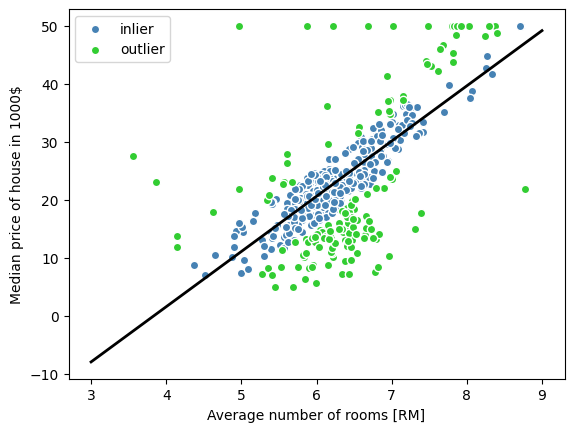

In [31]:
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)
line_X = np.arange(3,10,1)
line_y = ransac.predict(line_X[:,np.newaxis])
plt.scatter(X[inlier_mask],y[inlier_mask],c='steelblue',edgecolor='white',marker='o', label="inlier")
plt.scatter(X[outlier_mask],y[outlier_mask],c='limegreen',edgecolor='white',marker='o', label="outlier")
plt.plot(line_X,line_y,color='black',lw=2)
plt.xlabel("Average number of rooms [RM]")
plt.ylabel("Median price of house in 1000$")
plt.legend(loc="best")
plt.show()



as we can see the points far away from the model are labelled as outliers. the algorithm is able to separate the dataset into inliers and outliers. Is this approach improving or worsening the model? we need evaluation metrics to answer this question and this depends on the application


In [32]:
from sklearn.model_selection import train_test_split
X = df.iloc[:,:-1].values
y = df['MEDV'].values
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=0)
slr = LinearRegression()
slr.fit(X_train, y_train)
y_train_pred = slr.predict(X_train)
y_test_pred = slr.predict(X_test)


plotting y against multiple features which is held in X is cumbersome and not informative. instead we calculate residuals , which are differences between y_test and y_pred (vertical distances between actual and predicted values). They can help detect non-linearity and outliers.

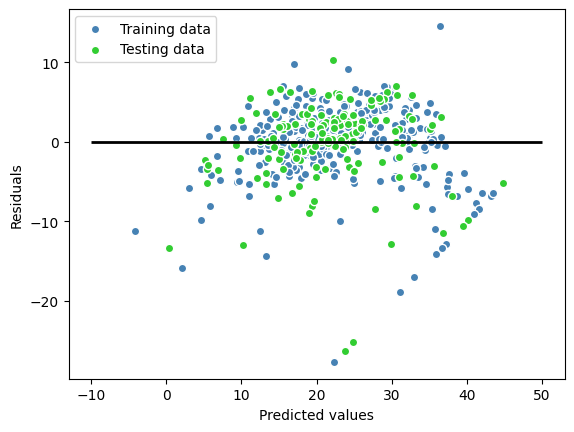

In [33]:
plt.scatter(y_train_pred, y_train_pred-y_train, c = 'steelblue', marker = 'o', edgecolor='white', label='Training data')
plt.scatter(y_test_pred, y_test_pred - y_test, color='limegreen', marker='o', edgecolor='white',label='Testing data')
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.hlines(y=0, xmin=-10, xmax=50, color='black', lw=2)
plt.legend(loc="best")
plt.show()

ideal scenario : all the residuals are zeros. but in practice , you do not get that. we can hope for residuals centered around value near zero and randomly distributed around the value near zero. if we see a pattern in the plot, it means the model has no captured all the information from the dataset in the prediction of the target variable.

Another useful measure is the Mean Squared Error (MSE) which can be used to check how good the predictions are.

In [34]:
from sklearn.metrics import mean_squared_error
print("MSE train :  %.3f, test : %.3f", mean_squared_error(y_train, y_train_pred), mean_squared_error(y_test, y_test_pred))

MSE train :  %.3f, test : %.3f 19.958219814238046 27.195965766883308


MSE on training set is 19.27 percent, while on test set , it is 27.1956 percent. this means that model is overfitting on the training data.

there is another metric called the $R^2$ , which is called coefficient of determination. it captures how much response variance is captured by the model. $R^2 = \frac{SSE}{SST}$, \
$SSE = \frac{1}{n} \sum (y^{(i)} - \hat{y}^{(i)})$, \
$SST = \frac{1}{n} \sum (y^{(i)} - \mu_y)$. \
 = 1 - MSE/Var(y)


In [35]:
from sklearn.metrics import r2_score
print("R^2 train : %.3f and R^2 test : %.3f" % (r2_score(y_train, y_train_pred), r2_score(y_test, y_test_pred)))

R^2 train : 0.765 and R^2 test : 0.673


higher the R^2, the better. in training predictions, we see a R^2 score of 0.765 and in test set, we see a drop to 0.673. hence, potential overfitting.

Regularization of regression models : \
Popular approaches : Ridge regression, LASSO (Least absolute Shrinkage and Selection operator), elastic net

Ridge regression: \
$J(w) = 0.5 (y^{(i)} - \hat{y}^{(i)})^2 + \lambda \Vert w \Vert ^2$, \
by increasing the parameter lambda, we can put more regularization on the model and penalize the model for being complex. this way , overfitting can be controlled.


LASSO regression : \
Lasso regression - instead of using sum of squares of weight
s, we use the absolute values of weights. \
J(w) = $0.5 (y^{(i)} - \hat{y}^{(i)})^2 + \lambda \Vert w \Vert$ \
In this approach, certain weights can become zeros -> meaning with m weights, we can have at most n weights, it generates sparsity.


A compromise between LASSO and Ridge regression is Elastic Net -> it generates sparsity of Lasso but also overcomes the challenges faced by LASSO such as number of selected variables. \
$J(w) = 0.5 (y^{(i)} - \hat{y}^{(i)})^2 + \lambda _1 \Vert w \Vert ^2 + \lambda _2 \Vert w \Vert $

In [36]:
#ridge regression in sklearn
from sklearn.linear_model import Ridge
ridge = Ridge(alpha=0.1)


In [37]:
#Lasso regression
from sklearn.linear_model import Lasso 
lasso = Lasso(alpha=0.1)


In [38]:
#Elastic net 
from sklearn.linear_model import ElasticNet
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5)
#l1_ratio is the proportion of weights for l1 and l2. if it is set to 1.0, l1_ratio = 1.0 and l2_ration = 0.0

Linear regression model to curve :
in the previous section, it was assumed a linear mapping was present between input variables X and the target variable y.this may not be the case necessarily, we could model the relationship as a curve where
y = w0 + w1*x + w2 * x^2 + w3 * x^3 ... \
this still could be interpreted as a multiple linear regression model because the coefficients w0,w1,w2 are still linear and a polynomial is formed out of the independent variable X

In [39]:
X = np.array([ 258.0, 270.0, 294.0, 320.0, 342.0,
              368.0, 396.0, 446.0, 480.0, 586.0])\
             [:, np.newaxis]

y = np.array([ 236.4, 234.4, 252.8, 298.6, 314.2,
            342.2, 360.8, 368.0, 391.2, 390.8])



In [41]:
from sklearn.preprocessing import PolynomialFeatures
lr = LinearRegression()
pr = LinearRegression()
quadratic = PolynomialFeatures(degree=2)
X_quad = quadratic.fit_transform(X)
print(X_quad)

[[1.00000e+00 2.58000e+02 6.65640e+04]
 [1.00000e+00 2.70000e+02 7.29000e+04]
 [1.00000e+00 2.94000e+02 8.64360e+04]
 [1.00000e+00 3.20000e+02 1.02400e+05]
 [1.00000e+00 3.42000e+02 1.16964e+05]
 [1.00000e+00 3.68000e+02 1.35424e+05]
 [1.00000e+00 3.96000e+02 1.56816e+05]
 [1.00000e+00 4.46000e+02 1.98916e+05]
 [1.00000e+00 4.80000e+02 2.30400e+05]
 [1.00000e+00 5.86000e+02 3.43396e+05]]


In [42]:
lr.fit(X, y)
X_fit= np.arange(250,600,10)[:,np.newaxis]
y_lin_fit = lr.predict(X_fit)


In [43]:
y_lin_fit

array([250.86164718, 256.26469105, 261.66773493, 267.0707788 ,
       272.47382268, 277.87686655, 283.27991043, 288.6829543 ,
       294.08599818, 299.48904205, 304.89208593, 310.2951298 ,
       315.69817368, 321.10121755, 326.50426142, 331.9073053 ,
       337.31034917, 342.71339305, 348.11643692, 353.5194808 ,
       358.92252467, 364.32556855, 369.72861242, 375.1316563 ,
       380.53470017, 385.93774405, 391.34078792, 396.7438318 ,
       402.14687567, 407.54991955, 412.95296342, 418.3560073 ,
       423.75905117, 429.16209505, 434.56513892])

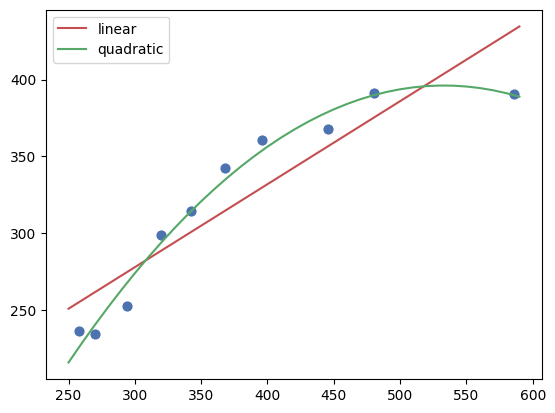

In [45]:
pr.fit(X_quad,y)
y_quad_fit = pr.predict(quadratic.fit_transform(X_fit))

plt.scatter(X,y,c='b', edgecolor='white',s=70)
plt.plot(X_fit, y_lin_fit, 'r',label='linear')
plt.plot(X_fit, y_quad_fit, 'g', label='quadratic')
plt.legend(loc="best")
plt.show()

In [46]:
y_lin_pred = lr.predict(X)
y_quad_pred =pr.predict(X_quad)
print('Training MSE linear : %.3f and Training MSE quadratic : %.3f' % (r2_score(y,y_lin_pred), r2_score(y,y_quad_pred)))

Training MSE linear : 0.832 and Training MSE quadratic : 0.982


MSE linear is 0.832 and MSE quadratic is 0.982 meaning the quadratic model is much better compared to the linear model.

Modeling non-linear relationship 

In [47]:
X = df[['LSTAT']].values
y = df['MEDV'].values

In [48]:
X.shape, y.shape

((506, 1), (506,))

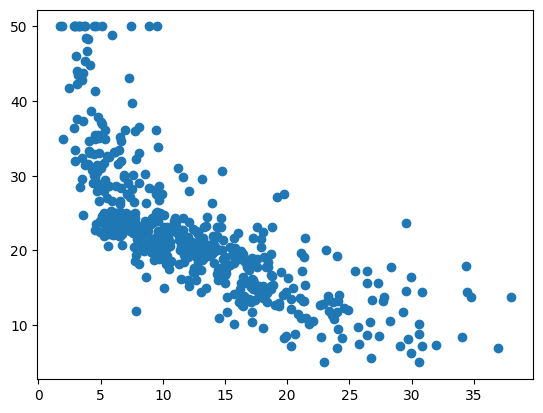

In [51]:
plt.scatter(X,y)
plt.show()

In [53]:
regr = LinearRegression()



In [54]:
quad = PolynomialFeatures(degree=2)
cubic = PolynomialFeatures(degree=3)
X_quad = quad.fit_transform(X)
X_cubic = cubic.fit_transform(X)



In [55]:
X_fit = np.arange(X.min(), X.max(),1)[:,np.newaxis]
X_fit.shape

(37, 1)

In [57]:
regr = regr.fit(X,y)
y_lin_fit = regr.predict(X_fit)
lin_r2_score = r2_score(y,regr.predict(X)) 

In [58]:
regr = regr.fit(X_quad,y)
y_quad_fit = regr.predict(quad.fit_transform(X_fit))
quad_r2_score = r2_score(y,regr.predict(X_quad)) 


In [59]:
regr = regr.fit(X_cubic,y)
y_cubic_fit = regr.predict(cubic.fit_transform(X_fit))
cubic_r2_score = r2_score(y,regr.predict(X_cubic))

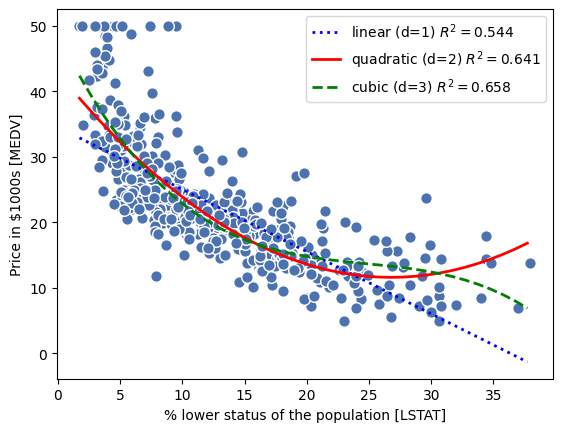

In [63]:
#plot results
plt.scatter(X,y,c='b',edgecolor='white',s=70)
plt.plot(X_fit,y_lin_fit,color='blue',label='linear (d=1) $R^2 = %.3f$' % (lin_r2_score),lw=2,linestyle=':')
plt.plot(X_fit,y_quad_fit, color='red', label='quadratic (d=2) $R^2 = %.3f$' % (quad_r2_score),lw=2,linestyle='-')
plt.plot(X_fit, y_cubic_fit, color='green', label='cubic (d=3) $R^2 = %.3f$' % (cubic_r2_score),  lw=2,linestyle='--')
plt.xlabel('% lower status of the population [LSTAT]')
plt.ylabel('Price in $1000s [MEDV]')
plt.legend(loc='upper right')
plt.show()

we observe that the cubic model has teh highest r2 score indicating that increasing the complexity does help in this case. However adding complexity to model usually leads to overfitting and should be used with care. in fact we could try other transformations of inputs before applying our linear regression model.[feature engineering]

for instance, f(x) = 2^-x could be a better mapping function. log(f(x)) = -x.

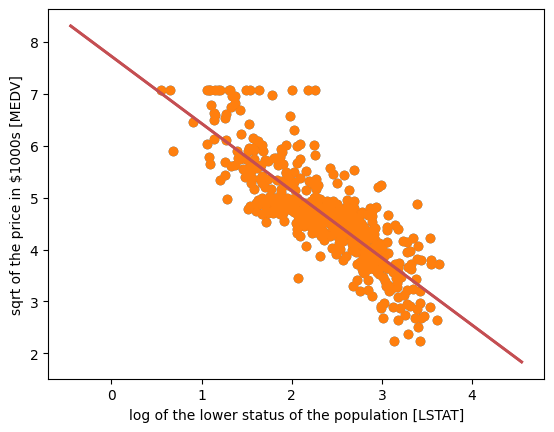

In [65]:
X_log =np.log(X)
y_sqrt = np.sqrt(y)
X_fit = np.arange(X_log.min()-1,X_log.max()+1,1)[:,np.newaxis]
regr = regr.fit(X_log,y_sqrt)
y_lin_fit = regr.predict(X_fit)
linear_r2 = r2_score(y_sqrt, regr.predict(X_log))
plt.scatter(X_log, y_sqrt)
plt.plot(X_fit, y_lin_fit, 'r',label='linear (d=1) $R^2 = %.3f$' % (linear_r2),lw=2, linestyle='-' )
plt.xlabel('log of the lower status of the population [LSTAT]')
plt.ylabel('sqrt of the price in $1000s [MEDV]')
plt.show()

Dealing with non-linear relationships using randomforest regression : 
Random forest regression is different from the linear or multiple linear regression discussed before.it tries to approximate the data using piecewise linear functions instead of a global function for the entire dataset. we are dividing the entire subset into piecewise linear function which become more manageable.

in classification task using random forest, we used a meaure of entropy [like gini or entropy] to measure the impurity at node t. for regression we may have to slighlty modify it. \
I(t) = MSE(t) = $\frac{1}{N_t} \sum _{i \in D_i} (y^{(i)} - \hat{y}_t)^2$ ,
where $N_t$ is the number of training samples at node t, y and $\hat{y}$ are the predicted and true targets. \
$\hat{y}_t$ is the predicted target i.e sample mean given by : \
$\hat{y}_t = \frac{1}{N_t} \sum y^{(i)}$ 

in the context of decision tree regression, the mse is seen as within node variance. so, the splitting of nodes in decision tree is in a way variance reduction.

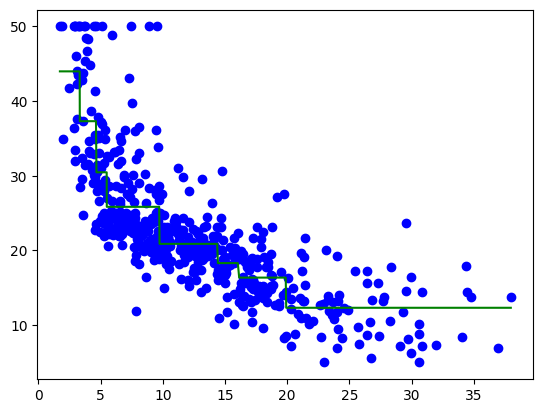

In [69]:
from sklearn.tree import DecisionTreeRegressor
X = df[['LSTAT']].values
y = df['MEDV'].values
tree = DecisionTreeRegressor(max_depth=3)
tree.fit(X,y)
sort_idx= X.flatten().argsort()
plt.scatter(X[sort_idx],y[sort_idx], c='blue',marker='o')
plt.plot(X[sort_idx], tree.predict(X[sort_idx]),c='green',linestyle='-')
plt.show()

we see that the plot is sort of a bunch of linera functions fit piecewise on data. decision tree does a good job but it has a bad habit, it overfits very easily. so , in practice,randomforest is used.

In [72]:
#random forest regression
X = df.iloc[:,:-1].values
y = df['MEDV'].values
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=0)
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(n_estimators=1000, criterion='squared_error', random_state=1, n_jobs=-1)
forest.fit(X_train, y_train)
y_train_pred  = forest.predict(X_train)
y_test_pred = forest.predict(X_test)
print("MSE train : %.3f, test : %.3f" % (mean_squared_error(y_train, y_train_pred), mean_squared_error(y_test, y_test_pred)))
 



MSE train : 1.424, test : 14.426


inspite of using random forest, which usually helps solve the overfitting problem, we see a dramatic increase in MSE compared to train MSE. we can have a look at the residual plot to see if there is leakage into the residuals

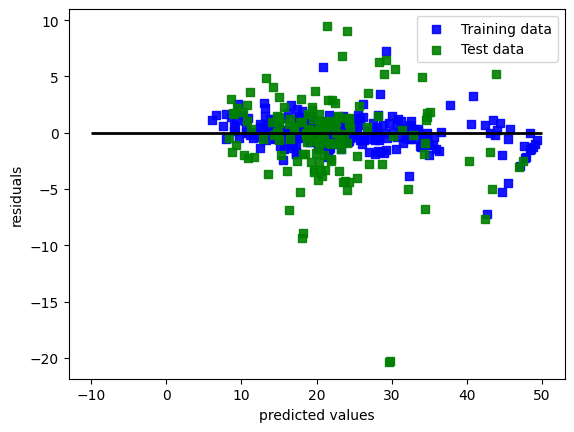

In [73]:
plt.scatter(y_train_pred, y_train_pred-y_train, c='blue', alpha=0.9, label='Training data', marker='s')
plt.scatter(y_test_pred, y_test_pred - y_test, c='green', alpha=0.9,label='Test data',marker='s')
plt.hlines(y=0,xmin=-10,xmax=50,color='black',lw=2)
plt.xlabel('predicted values')
plt.ylabel('residuals')
plt.legend(loc='best')
plt.show()


ideally, the distribution of residuals should be random, but we see a pattern in some parts of the plot above indicating leakage of residuals. this is a problem encountered often and we should experiment with multiple approaches to mitigate the problem. maybe removing a few features, adding regularization could benefit us.

Similar to how support vector machine was used for solving classification of non-linear data, we can use SVM for regression as well.sklearn has an implementation which can be readily used.